In [1]:
# default_exp experiments.nbeats.hyperopt_epf

In [2]:
# export
import time
import os
# Limit number of threads in numpy and others to avoid throttling
os.environ["OMP_NUM_THREADS"] = "2" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "2" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "3" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "2" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "3" # export NUMEXPR_NUM_THREADS=6

import numpy as np
import pandas as pd
import argparse
import pickle
import glob
import itertools
import random
from datetime import datetime
from functools import partial

from nixtla.data.scalers import Scaler
from nixtla.data.datasets.epf import EPF, EPFInfo
from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_fast import TimeSeriesLoader
from nixtla.losses.numpy import mae, mape, smape, rmse, pinball_loss

# Models
from nixtla.models.nbeats.nbeats import Nbeats

import warnings
warnings.filterwarnings("ignore")

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# DATA WRANGLING AND EVALUATION UTILS

In [3]:
# export
# TODO: Think and test new mask_df and datasets with random validation

############################################################################################
#### COMMON
############################################################################################

BENCHMARK_DF = pd.DataFrame({'id': [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5],
                             'unique_id': ['NP', 'NP', 'NP', 'NP', 'PJM', 'PJM', 'PJM', 'PJM',
                                           'BE', 'BE', 'BE', 'BE', 'FR', 'FR', 'FR', 'FR',
                                           'DE', 'DE', 'DE', 'DE'],
                             'metric': ['MAE', 'MAPE', 'SMAPE', 'RMSE', 'MAE', 'MAPE', 'SMAPE', 'RMSE',
                                        'MAE', 'MAPE', 'SMAPE', 'RMSE', 'MAE', 'MAPE', 'SMAPE', 'RMSE',
                                        'MAE', 'MAPE', 'SMAPE', 'RMSE',],
                             'DNN_ens' : [1.67, 5.38, 4.85, 3.33, 2.78, 28.66, 11.22, 4.64, 
                                          5.82, 26.11, 13.33, 16.13, 3.91, 14.77, 10.98, 11.74,
                                          3.44, 95.76, 14.19, 6.00],
                             'DNN_best': [1.72, 5.46, 5.00, 3.34, 2.95, 29.10, 11.81, 4.82,
                                          6.07, 24.08, 13.87, 15.88, 4.19, 15.13, 11.65, 11.41,
                                          3.60, 83.1, 14.74, 6.13]})

def forecast_evaluation_table(y_total, y_hat_total, meta_data):
    performances = []
    for i, market_data in enumerate(meta_data):
        market = market_data['unique_id']
        
        y = y_total[i,:,:].reshape(-1)
        y_hat = y_hat_total[i,:,:].reshape(-1)

        _mae   = np.round(mae(y=y, y_hat=y_hat),5)
        _mape  = np.round(mape(y=y, y_hat=y_hat),5)
        _smape = np.round(smape(y=y, y_hat=y_hat),5)
        _rmse  = np.round(rmse(y=y, y_hat=y_hat),5)

        performance_df = pd.DataFrame({'unique_id': [market]*4,
                                       'metric': ['MAE', 'MAPE', 'SMAPE', 'RMSE'],
                                       'NBEATSx': [_mae, _mape, _smape, _rmse]})

        performances += [performance_df]

    performances_df = pd.concat(performances)

    benchmark_df = BENCHMARK_DF.merge(performances_df, on=['unique_id', 'metric'], how='left')
    benchmark_df['perc_diff'] = 100 * (benchmark_df['NBEATSx']-benchmark_df['DNN_ens'])/benchmark_df['DNN_ens']
    benchmark_df['improvement'] = benchmark_df['perc_diff'] < 0
    benchmark_df = benchmark_df.dropna()
    average_perc_diff = benchmark_df['perc_diff'].mean()

    
    y_tot = y_total.reshape(-1)
    y_hat_tot = y_hat_total.reshape(-1)
    y_total_nans_perc = np.sum((np.isnan(y_tot)))  / len(y_tot)
    y_hat_total_nans_perc = np.sum((np.isnan(y_hat_tot)))  / len(y_hat_tot)
    print(f'y_total {len(y_tot)} nan_perc {y_total_nans_perc}')
    print(f'y_hat_total {len(y_tot)} nan_perc {y_total_nans_perc}')
    print("average_perc_diff", average_perc_diff)

    reported_loss = _mae
    if y_total_nans_perc > 0: reported_loss=500
    if y_hat_total_nans_perc > 0: reported_loss=500
    #improvement_loss = 200 * (1-np.mean(benchmark_df.improvement)) + average_perc_diff
    print(f'reported_loss {reported_loss}')

    return benchmark_df, y_total_nans_perc, y_hat_total_nans_perc, reported_loss

def protect_nan_reported_loss(model):
    # TODO: Pytorch numerical error hacky protection, protect from losses.numpy.py
    reported_loss = model.final_outsample_loss
    if np.isnan(model.final_insample_loss):
        reported_loss = 500
    if model.final_insample_loss<=0:
        reported_loss = 500

    if np.isnan(model.final_outsample_loss):
        reported_loss = 500    
    if model.final_outsample_loss<=0:
        reported_loss = 500    
    return reported_loss

def get_mask_df(Y_df, n_timestamps):
    # Creates outsample_mask
    # train 1 validation 0

    last_df = Y_df.copy()[['unique_id', 'ds']]
    last_df.sort_values(by=['unique_id', 'ds'], inplace=True, ascending=False)
    last_df.reset_index(drop=True, inplace=True)

    last_df = last_df.groupby('unique_id').head(n_timestamps)
    last_df['sample_mask'] = 0

    last_df = last_df[['unique_id', 'ds', 'sample_mask']]

    mask_df = Y_df.merge(last_df, on=['unique_id', 'ds'], how='left')
    mask_df['sample_mask'] = mask_df['sample_mask'].fillna(1)    # The first len(Y)-n_hours used as train

    mask_df = mask_df[['unique_id', 'ds', 'sample_mask']]
    mask_df.sort_values(by=['unique_id', 'ds'], inplace=True)
    mask_df['available_mask'] = 1

    assert len(mask_df)==len(Y_df), \
        f'The mask_df length {len(mask_df)} is not equal to Y_df length {len(Y_df)}'

    return mask_df

def balance_data(Y_df, X_df):
    # Create balanced placeholder dataframe
    balance_ids = {'unique_id': Y_df.unique_id.unique(),
                   'ds': Y_df.ds.unique()}

    product_list = list(itertools.product(*list(balance_ids.values())))
    balance_df = pd.DataFrame(product_list, columns=list(balance_ids.keys()))
    
    # Balance with merge
    Y_balanced_df = balance_df.merge(Y_df, on=['unique_id', 'ds'], how='left')
    X_balanced_df = balance_df.merge(X_df, on=['unique_id', 'ds'], how='left')

    print('\n')
    print(f'Y_df.shape \t{Y_df.shape}')
    print(f'X_df.shape \t{X_df.shape}')
    print(f'Y_balanced_df.shape \t{Y_balanced_df.shape}')
    print(f'X_balanced_df.shape \t{X_balanced_df.shape}')

    return Y_balanced_df, X_balanced_df

def scale_data(Y_df, X_df, mask_df, normalizer_y, normalizer_x):
    y_shift = None
    y_scale = None

    # mask = mask.astype(int)
    mask = mask_df['available_mask'].values * mask_df['sample_mask'].values
    
    if normalizer_y is not None:
        scaler_y = Scaler(normalizer=normalizer_y)
        Y_df['y'] = scaler_y.scale(x=Y_df['y'].values, mask=mask)
    else:
        scaler_y = None
    # Exogenous are always scaled to help learning
    if normalizer_x is not None:
        scaler_x = Scaler(normalizer=normalizer_x)
        X_df['Exogenous1'] = scaler_x.scale(x=X_df['Exogenous1'].values, mask=mask)

        scaler_x = Scaler(normalizer=normalizer_x)
        X_df['Exogenous2'] = scaler_x.scale(x=X_df['Exogenous2'].values, mask=mask)

    filter_variables = ['unique_id', 'ds', 'Exogenous1', 'Exogenous2', 'week_day'] + \
                       [col for col in X_df if (col.startswith('day'))]
                       #[col for col in X_df if (col.startswith('_hour_'))]
    X_df = X_df[filter_variables]

    return Y_df, X_df, scaler_y


############################################################################################
#### KIN
############################################################################################

def prepare_data(mc, Y_df, X_df, S_df, n_timestamps_pred=365*1*24, offset=0): #offset=365*1*24 tira un año
    # n_timestamps_pred defines number of hours ahead to predict
    # offset defines the shift of the data to simulate rolling window
    assert offset % n_timestamps_pred == 0, 'Avoid overlap of predictions, redefine n_timestamps_pred or offset'
    Y_df = Y_df.head(len(Y_df)-offset)
    X_df = X_df.head(len(X_df)-offset)

    assert len(Y_df.unique_id.unique())==1, 'Data prepartation for more than one market not implemented yet'

    #-------------------------------------------- Data Wrangling --------------------------------------------#
    Y_balanced_df, X_balanced_df = balance_data(Y_df, X_df)
    del Y_df, X_df

    #------------------------------------- Available and Validation Mask ------------------------------------#
    # mask: 1 last_n_timestamps, 0 timestamps until last_n_timestamps
    mask_df = get_mask_df(Y_df=Y_balanced_df, n_timestamps=n_timestamps_pred)
    val_mask_df = mask_df.copy()
    val_mask_df['sample_mask'] = 1 - val_mask_df['sample_mask']
    # mask_df['available_mask'] = (1-Y_balanced_df.y.isnull().values)
    # mask_df['sample_mask'] = (1-last_timestamps_df['mask'])

    # Plotting train validation splits
    #y_train = Y_balanced_df[mask_df.sample_mask==1].y.values
    #y_val = Y_balanced_df[mask_df.sample_mask==0].y.values
    #plt.plot(y_train, label='train', color='blue')
    #plt.plot(np.array(range(len(y_val))) + len(y_train), y_val, label='val', color='purple')
    #plt.legend()
    #plt.show()

    #---------------------------------------------- Scale Data ----------------------------------------------#

    # Scale data # TODO: write sample_mask conditional/groupby(['unique_id]) scaling
    Y_scaled_df, X_scaled_df, scaler_y = scale_data(Y_df=Y_balanced_df, X_df=X_balanced_df, mask_df=mask_df,
                                                    normalizer_y=mc['normalizer_y'], normalizer_x=mc['normalizer_x'])
    del Y_balanced_df
    del X_balanced_df

    #-------------------------------------------- Declare Loaders -------------------------------------------#

    train_ts_dataset = TimeSeriesDataset(Y_df=Y_scaled_df, X_df=X_scaled_df, S_df=S_df, mask_df=mask_df)
    val_ts_dataset = TimeSeriesDataset(Y_df=Y_scaled_df, X_df=X_scaled_df, S_df=S_df, mask_df=val_mask_df)
    
    train_ts_loader = TimeSeriesLoader(ts_dataset=train_ts_dataset,
                                       model='nbeats',
                                       offset=0,
                                       #window_sampling_limit=ts_dataset.max_len,
                                       window_sampling_limit=int(mc['window_sampling_limit']),
                                       input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                       output_size=int(mc['output_size']),
                                       idx_to_sample_freq=int(mc['idx_to_sample_freq']),
                                       batch_size=int(mc['batch_size']),
                                       complete_inputs=mc['complete_inputs'],
                                       complete_sample=False,
                                       shuffle=True)

    print("train_ts_loader.ts_windows.shape", train_ts_loader.ts_windows.shape)
    print(f"len(train_sampling_windows) * 24 = {len(train_ts_loader.windows_sampling_idx)} * 24 = {len(train_ts_loader.windows_sampling_idx) * 24}")
    print("\n")

    val_ts_loader = TimeSeriesLoader(ts_dataset=val_ts_dataset,
                                       model='nbeats',
                                       offset=0,
                                       #window_sampling_limit=ts_dataset.max_len,
                                       window_sampling_limit=int(mc['window_sampling_limit']),
                                       input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                       output_size=int(mc['output_size']),
                                       #idx_to_sample_freq=int(mc['idx_to_sample_freq']),
                                       idx_to_sample_freq=24,
                                       batch_size=int(mc['batch_size']),
                                       complete_inputs=False,
                                       complete_sample=True,
                                       shuffle=False)

    print("val_ts_loader.ts_windows.shape", val_ts_loader.ts_windows.shape)
    print(f"len(val_sampling_windows) * 24 = {len(val_ts_loader.windows_sampling_idx)} * 24 = {len(val_ts_loader.windows_sampling_idx) * 24}")
    print("\n")

    mc['t_cols'] = train_ts_dataset.t_cols
    return mc, train_ts_loader, val_ts_loader, scaler_y


def model_fit_predict_roll(mc, Y_df, X_df, S_df, n_timestamps_pred, offsets):

    X_raw_df = X_df.copy()
    Y_raw_df = Y_df.copy()

    #-------------------------------------- Rolling prediction on test --------------------------------------#

    y_true_list = []
    y_hat_list = []
    mask_list = []
    #offsets = [365*1*24, 0]
    n_splits = len(offsets)
    for split, offset in enumerate(offsets):
        print(10*'-', f'Split {split+1}/{n_splits}', 10*'-')

        #----------------------------------------------- Data -----------------------------------------------#
        mc, train_ts_loader, val_ts_loader, scaler_y = prepare_data(mc=mc, Y_df=Y_raw_df, X_df=X_raw_df,
                                                                    S_df=S_df, n_timestamps_pred=n_timestamps_pred,
                                                                    offset=offset)

        #--------------------------------------- Finetune and predict ---------------------------------------#
        # Instantiate and train model
        model = Nbeats(input_size_multiplier=mc['input_size_multiplier'],
                       output_size=int(mc['output_size']),
                       shared_weights=mc['shared_weights'],
                       initialization=mc['initialization'],
                       activation=mc['activation'],
                       stack_types=mc['stack_types'],
                       n_blocks=mc['n_blocks'],
                       n_layers=mc['n_layers'],
                       #n_hidden=2*[2*[int(mc['n_hidden'])]], # TODO; Revisar n_hidden1, n_hidden2 <------
                       n_hidden=mc['n_hidden_list'],
                       #n_hidden=2*[[256,256]],
                       n_harmonics=int(mc['n_harmonics']),
                       n_polynomials=int(mc['n_polynomials']),
                       x_s_n_hidden = 0,#int(mc['x_s_n_hidden']),
                       exogenous_n_channels=int(mc['exogenous_n_channels']),
                       include_var_dict=mc['include_var_dict'],
                       t_cols=mc['t_cols'],
                       batch_normalization = mc['batch_normalization'],
                       dropout_prob_theta=mc['dropout_prob_theta'],
                       dropout_prob_exogenous=mc['dropout_prob_exogenous'],
                       learning_rate=float(mc['learning_rate']),
                       lr_decay=float(mc['lr_decay']),
                       n_lr_decay_steps=float(mc['n_lr_decay_steps']),
                       weight_decay=mc['weight_decay'],
                       l1_theta=mc['l1_theta'],
                       n_iterations=int(mc['n_iterations']),
                       early_stopping=int(mc['early_stopping']),
                       loss=mc['loss'],
                       loss_hypar=float(mc['loss_hypar']),
                       val_loss=mc['val_loss'],
                       frequency=mc['frequency'],
                       seasonality=int(mc['seasonality']),
                       random_seed=int(mc['random_seed']))

        model.fit(train_ts_loader=train_ts_loader, val_ts_loader=val_ts_loader, eval_steps=mc['eval_steps'])
        y_true, y_hat, mask = model.predict(ts_loader=val_ts_loader, eval_mode=True)
        y_true_list.append(y_true)
        y_hat_list.append(y_hat)
        mask_list.append(mask)
    y_total = np.vstack(y_true_list)
    y_hat_total = np.vstack(y_hat_list)
    mask_total = np.vstack(mask_list)

    print(f'y_total.shape (#n_windows, #lt) {y_total.shape}')
    print(f'y_hat_total.shape (#n_windows, #lt) {y_hat_total.shape}')
    print("\n")

    # Reshape for univariate and panel model compatibility
    n_series = train_ts_loader.ts_dataset.n_series
    n_fcds = len(y_total) // n_series
    y_total = y_total.reshape(n_series, n_fcds, mc['output_size'])
    y_hat_total = y_hat_total.reshape(n_series, n_fcds, mc['output_size'])

    print("y_total.shape (#n_series, #n_fcds, #lt) ", y_total.shape)
    print("y_hat_total.shape (#n_series, #n_fcds, #lt) ", y_hat_total.shape)
    print("\n")

    meta_data = val_ts_loader.ts_dataset.meta_data

    return y_total, y_hat_total, mask_total, meta_data, model


############################################################################################
#### CRISTIAN
############################################################################################

def train_val_split(len_series, offset, window_sampling_limit, n_val_weeks, ds_per_day):
    last_ds = len_series - offset
    first_ds = max(last_ds - window_sampling_limit, 0)

    last_day = int(last_ds/ds_per_day)
    first_day = int(first_ds/ds_per_day)

    days = set(range(first_day, last_day)) # All days, to later get train days
    # Sample weeks from here, -7 to avoid sampling from last week
    # To not sample first week and have inputs
    sampling_days = set(range(first_day + 7, last_day - 7))
    validation_days = set({}) # Val days set
    
    # For loop for n of weeks in validation
    for i in range(n_val_weeks):
        # Sample random day, init of week
        init_day = random.sample(sampling_days, 1)[0]
        # Select days of sampled init of week
        sampled_days = list(range(init_day, min(init_day+7, last_day)))
        # Add days to validation days
        validation_days.update(sampled_days)
        # Remove days from sampling_days, including overlapping resulting previous week
        days_to_remove = set(range(init_day-6, min(init_day+7, last_day)))
        sampling_days = sampling_days.difference(days_to_remove)

    train_days = days.difference(validation_days)

    train_days = sorted(list(train_days))
    validation_days = sorted(list(validation_days))

    train_idx = []
    for day in train_days:
        hours_idx = range(day*ds_per_day,(day+1)*ds_per_day)
        train_idx += hours_idx

    val_idx = []
    for day in validation_days:
        hours_idx = range(day*ds_per_day,(day+1)*ds_per_day)
        val_idx += hours_idx

    assert all([idx < last_ds for idx in val_idx]), 'Leakage!!!!'
    
    return train_idx, val_idx

# RUN VALIDATION CODE

In [4]:
# export
# run_val_nbeatsx(hyperparameters, Y_df, X_df, data_augmentation, random_validation, trials, trials_file_name)
def run_val_nbeatsx(mc, Y_df, X_df, S_df, trials, trials_file_name, final_evaluation=False, return_predictions=False):

    # Save trials, can analyze progress
    if trials is not None:
        save_every_n_step = 5
        current_step = len(trials.trials)
        if (current_step % save_every_n_step==0):
            with open(trials_file_name, "wb") as f:
                pickle.dump(trials, f)

    start_time = time.time()    
    
    #---------------------------------------- Parse  Hyperparameters ----------------------------------------#
    mc['include_var_dict'] = {'y': [-2, -3, -8],
                              'Exogenous1': [-1, -2, -8],
                              'Exogenous2': [-1, -2, -8],
                              'week_day': [-1]}

    n_hidden = int(mc['n_hidden'])
    mc['n_hidden_list'] =  2*[[n_hidden, n_hidden]]
    
    #---------------------------------- Instantiate model, fit and predict ----------------------------------#

    y_total, y_hat_total, mask_total, meta_data, model = model_fit_predict_roll(mc=mc, Y_df=Y_df, X_df=X_df, S_df=S_df,
                                                                                offsets=[0], n_timestamps_pred=728*24)

    # y_total, y_hat_total, mask_total, meta_data, model = model_fit_predict_roll(mc=mc, Y_df=Y_df, X_df=X_df, S_df=S_df,
    #                                                                 offsets=[365*1*24, 0], n_timestamps_pred=365*1*24)

    # y_total, y_hat_total, mask_total, meta_data, model = model_fit_predict_roll(mc=mc, Y_df=Y_df, X_df=X_df, S_df=S_df,
    #                                                                             offsets=[9*73*24, 8*73*24, 7*73*24, 6*73*24, 5*73*24,
    #                                                                             4*73*24, 3*73*24, 2*73*24, 1*73*24, 0],
    #                                                                             n_timestamps_pred=73*24)

    print('Best Model Evaluation')
    benchmark_df, y_total_nans_perc, y_hat_total_nans_perc, reported_loss = forecast_evaluation_table(y_total=y_total, 
                                                                                                      y_hat_total=y_hat_total, 
                                                                                                      meta_data=meta_data)
    print(benchmark_df)
    print('\n')
    
    # CONDITIONAL ON CORRECT PREDICTION 
    # Average percentage difference of MAE, SMAPE, MAPE, RMSE
    #reported_loss = protect_nan_reported_loss(model)
    run_time = time.time() - start_time

    results =  {'loss': reported_loss,
                'loss_name': mc['val_loss'],
                'mc': mc,
                'final_insample_loss': model.final_insample_loss,
                'final_outsample_loss': model.final_outsample_loss,
                'trajectories': model.trajectories,
                'run_time': run_time,
                'status': STATUS_OK}
    
    if final_evaluation:
        print('Best Model Hyperpars')
        print(75*'=')
        print(pd.Series(mc))
        print(75*'='+'\n')
    
    if return_predictions:
        return y_total, y_hat_total, mask_total, meta_data
    
    return results
    

# EXPERIMENT SPACES

In [5]:
#export
# TODO: eliminate n_harmonics, n_polynomials think on kwargs maybe?
# TODO: think on n_consistency for exogenous_n_channels -> n_xt_channels
# TODO: x_s_n_hidden -> n_xs_hidden
# TODO: input_size_multiplier -> Change for n_xt?
# TODO: n_hidden -> n_theta_list
def get_experiment_space(args):
    if args.space=='nbeats_cristian':
        space = {# Architecture parameters
                 'input_size_multiplier': hp.choice('input_size_multiplier', [7]),
                 'output_size': hp.choice('output_size', [24]),
                 'shared_weights': hp.choice('shared_weights', [False]),
                 'activation': hp.choice('activation', ['relu','softplus','tanh','selu','lrelu','prelu','sigmoid']),
                 'initialization':  hp.choice('initialization', ['orthogonal','he_uniform','he_normal',
                                                                 'glorot_uniform','glorot_normal','lecun_normal']),
                 'stack_types': hp.choice('stack_types', [ ['identity'],
                                                            1*['identity']+['exogenous_wavenet'],
                                                                ['exogenous_wavenet']+1*['identity'],
                                                            1*['identity']+['exogenous_tcn'],
                                                                ['exogenous_tcn']+1*['identity'] ]),
                 'n_blocks': hp.choice('n_blocks', [ [1, 1] ]),
                 'n_layers': hp.choice('n_layers', [ [2, 2] ]),
                 'n_hidden': hp.quniform('n_hidden', 50, 500, 1),
                 'n_harmonics': hp.choice('n_harmonics', [1]),
                 'n_polynomials': hp.choice('n_polynomials', [2]),
                 'exogenous_n_channels': hp.quniform('exogenous_n_channels', 1, 10, 1),
                 'x_s_n_hidden': hp.choice('x_s_n_hidden', [0]),
                 # Regularization and optimization parameters
                 'batch_normalization': hp.choice('batch_normalization', [True, False]),
                 'dropout_prob_theta': hp.uniform('dropout_prob_theta', 0, 1),
                 'dropout_prob_exogenous': hp.uniform('dropout_prob_exogenous', 0, 0.5),
                 'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.1)),
                 'lr_decay': hp.choice('lr_decay', [0.5]),
                 'n_lr_decay_steps': hp.choice('n_lr_decay_steps', [3]),
                 'weight_decay': hp.loguniform('weight_decay', np.log(5e-4), np.log(0.01)),
                 'n_iterations': hp.choice('n_iterations', [args.max_epochs]),
                 'early_stopping': hp.choice('early_stopping', [8]),
                 'eval_steps': hp.choice('eval_steps', [50]),
                 #'n_val_weeks': hp.choice('n_val_weeks', [52]),
                 'n_val_weeks': hp.choice('n_val_weeks', [52*2]),
                 'loss': hp.choice('loss', ['MAE']),
                 'loss_hypar': hp.choice('loss_hypar', [0.5]),
                 'val_loss': hp.choice('val_loss', [args.val_loss]),
                 'l1_theta': hp.choice('l1_theta', [0, hp.loguniform('lambdal1', np.log(1e-5), np.log(1))]),
                 # Data parameters
                 'normalizer_y': hp.choice('normalizer_y', [None, 'norm', 'norm1', 
                                                            'std', 'median', 'invariant']),
                 'normalizer_x': hp.choice('normalizer_x', [None, 'norm', 'norm1',
                                                            'std', 'median', 'invariant']),
                 'window_sampling_limit': hp.choice('window_sampling_limit', [50_000]),
                 'complete_inputs': hp.choice('complete_inputs', [True]),
                 'frequency': hp.choice('frequency', ['H']),
                 'seasonality': hp.choice('seasonality', [24]),
                 'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [24]),
                 'batch_size': hp.choice('batch_size', [128, 256, 512]),
                 'random_seed': hp.quniform('random_seed', 1, 1000, 1)}
                 # CONSIDERO ESTO INNECESARIO
                 # 'n_hidden_1': hp.quniform('n_hidden_1', 50, 500, 1),
                 # 'n_hidden_2': hp.quniform('n_hidden_2', 50, 500, 1),
                 # 'include_var_dict': hp.choice('include_var_dict', [{'y': [-2, -3, -8],
                 #                                                     'Exogenous1': [-1, -2, -8],
                 #                                                     'Exogenous2': [-1, -2, -8],
                 #                                                     'week_day': [-1]}]),                 
                 # 'incl_pr1': hp.choice('incl_pr1', [True]),
                 # 'incl_pr2': hp.choice('incl_pr2', [True, False]),
                 # 'incl_pr3': hp.choice('incl_pr3', [True, False]),
                 # 'incl_pr7': hp.choice('incl_pr7', [True, False]),
                 # 'incl_ex1_0': hp.choice('incl_ex1_0', [True, False]),
                 # 'incl_ex1_1': hp.choice('incl_ex1_1', [True, False]),
                 # 'incl_ex1_7': hp.choice('incl_ex1_7', [True, False]),
                 # 'incl_ex2_0': hp.choice('incl_ex2_0', [True, False]),
                 # 'incl_ex2_1': hp.choice('incl_ex2_1', [True, False]),
                 # 'incl_ex2_7': hp.choice('incl_ex2_7', [True, False]),
                 # 'incl_day': hp.choice('incl_day', [True, False]),
                 # 'args.data_augmentation'
                 # 'n_val_weeks': hp.choice('n_val_weeks', [args.n_val_weeks]}

    elif args.space=='nbeats_collapsed':
        space= {# Architecture parameters
                'input_size_multiplier': hp.choice('input_size_multiplier', [7]),
                'output_size': hp.choice('output_size', [24]),
                'shared_weights': hp.choice('shared_weights', [False]),
                'activation': hp.choice('activation', ['relu','softplus','tanh','selu','lrelu','prelu','sigmoid']),
                'initialization':  hp.choice('initialization', ['orthogonal','he_uniform','he_normal',
                                                                'glorot_uniform','glorot_normal','lecun_normal']),
                'stack_types': hp.choice('stack_types', [['exogenous_wavenet']+1*['identity'],
                                                         ['exogenous_tcn']+1*['identity'] ]),
                'n_blocks': hp.choice('n_blocks', [ [1, 1] ]),
                'n_layers': hp.choice('n_layers', [ [2, 2] ]),
                'n_hidden': hp.quniform('n_hidden', 50, 500, 1),
                'n_harmonics': hp.choice('n_harmonics', [1]),
                'n_polynomials': hp.choice('n_polynomials', [2]),
                'exogenous_n_channels': hp.quniform('exogenous_n_channels', 1, 10, 1),
                'x_s_n_hidden': hp.choice('x_s_n_hidden', [0]),
                # Regularization and optimization parameters
                'batch_normalization': hp.choice('batch_normalization', [False]),
                'dropout_prob_theta': hp.uniform('dropout_prob_theta', 0, 1),
                'dropout_prob_exogenous': hp.uniform('dropout_prob_exogenous', 0, 0.5),
                'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.1)),
                'lr_decay': hp.uniform('lr_decay', 0.3, 1.0),
                'n_lr_decay_steps': hp.choice('n_lr_decay_steps', [3]),
                'weight_decay': hp.loguniform('weight_decay', np.log(5e-5), np.log(5e-3)),
                'n_iterations': hp.choice('n_iterations', [args.max_epochs]),
                'early_stopping': hp.choice('early_stopping', [8]),
                'eval_steps': hp.choice('eval_steps', [50]),
                'n_val_weeks': hp.choice('n_val_weeks', [52*2]),
                #'loss': hp.choice('loss', ['PINBALL']),
                #'loss_hypar': hp.uniform('loss_hypar', 0.48, 0.51),
                'loss': hp.choice('loss', ['MAE']),
                'loss_hypar': hp.choice('loss_hypar', [0.5]),                
                'val_loss': hp.choice('val_loss', [args.val_loss]),
                'l1_theta': hp.choice('l1_theta', [0, hp.loguniform('lambdal1', np.log(1e-5), np.log(1))]),
                # Data parameters
                'normalizer_y': hp.choice('normalizer_y', [None]),
                'normalizer_x': hp.choice('normalizer_x', ['median']),
                'window_sampling_limit': hp.choice('window_sampling_limit', [50_000]),
                'complete_inputs': hp.choice('complete_inputs', [True]),
                'frequency': hp.choice('frequency', ['H']),
                'seasonality': hp.choice('seasonality', [24]),
                'include_var_dict': hp.choice('include_var_dict', [{'y': [-2, -3, -8],
                                                                    'Exogenous1': [-1, -2, -8],
                                                                    'Exogenous2': [-1, -2, -8],
                                                                    'week_day': [-1]}]),
                'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [24]),
                'batch_size': hp.choice('batch_size', [256]),
                'random_seed': hp.quniform('random_seed', 10, 20, 1)}
    
    elif args.space=='nbeats_collapsed2':
        space= {# Architecture parameters
                'input_size_multiplier': hp.choice('input_size_multiplier', [7]),
                'output_size': hp.choice('output_size', [24]),
                'shared_weights': hp.choice('shared_weights', [False]),
                'activation': hp.choice('activation', ['selu']),
                'initialization':  hp.choice('initialization', ['glorot_normal','he_normal']),
                'stack_types': hp.choice('stack_types', [2*['identity'],
                                                         1*['identity']+1*['exogenous_tcn'],
                                                         1*['exogenous_tcn']+1*['identity'] ]),
                'n_blocks': hp.choice('n_blocks', [ [1, 1] ]),
                'n_layers': hp.choice('n_layers', [ [2, 2] ]),
                #'n_hidden': hp.choice('n_hidden', [400]),
                'n_hidden': hp.choice('n_hidden', [400]),
                'n_harmonics': hp.choice('n_harmonics', [1]),
                'n_polynomials': hp.choice('n_polynomials', [2]),
                'exogenous_n_channels': hp.quniform('exogenous_n_channels', 1, 10, 1),
                'x_s_n_hidden': hp.choice('x_s_n_hidden', [0]),
                # Regularization and optimization parameters
                'batch_normalization': hp.choice('batch_normalization', [False]),
                'dropout_prob_theta': hp.uniform('dropout_prob_theta', 0, 0.5),
                'dropout_prob_exogenous': hp.uniform('dropout_prob_exogenous', 0, 0.5),
                'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.001)),
                'lr_decay': hp.uniform('lr_decay', 0.3, 0.5),
                'n_lr_decay_steps': hp.choice('n_lr_decay_steps', [3]),
                'weight_decay': hp.loguniform('weight_decay', np.log(5e-5), np.log(5e-3)),
                'n_iterations': hp.choice('n_iterations', [args.max_epochs]),
                'early_stopping': hp.choice('early_stopping', [16]),
                'eval_steps': hp.choice('eval_steps', [50]),
                'n_val_weeks': hp.choice('n_val_weeks', [52*2]),
                #'loss': hp.choice('loss', ['PINBALL']),
                #'loss_hypar': hp.uniform('loss_hypar', 0.48, 0.51),
                'loss': hp.choice('loss', ['MAE']),
                'loss_hypar': hp.choice('loss_hypar', [0.5]),                
                'val_loss': hp.choice('val_loss', [args.val_loss]),
                'l1_theta': hp.choice('l1_theta', [0]),
                # Data parameters
                'normalizer_y': hp.choice('normalizer_y', [None]),
                'normalizer_x': hp.choice('normalizer_x', ['median']),
                'window_sampling_limit': hp.choice('window_sampling_limit', [50_000]),
                'complete_inputs': hp.choice('complete_inputs', [True]),                
                'frequency': hp.choice('frequency', ['H']),
                'seasonality': hp.choice('seasonality', [24]),
                'include_var_dict': hp.choice('include_var_dict', [{'y': [-2, -3, -8],
                                                                    'Exogenous1': [-1, -2, -8],
                                                                    'Exogenous2': [-1, -2, -8],
                                                                    'week_day': [-1]}]),
                'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [24]),
                'batch_size': hp.choice('batch_size', [256]),
                'random_seed': hp.quniform('random_seed', 10, 20, 1)}                
    
    else:
        print(f'Experiment space {args.space} not available')

    return space

def parse_trials(trials):
    # Initialize
    trials_dict = {'tid': [], 'loss': [], 'trajectories': [], 'mc': []}
    for tidx in range(len(trials)):
        # Main
        trials_dict['tid']  += [trials.trials[tidx]['tid']]
        trials_dict['loss'] += [trials.trials[tidx]['result']['loss']]
        trials_dict['trajectories'] += [trials.trials[tidx]['result']['trajectories']]

        # Model Configs
        mc = trials.trials[tidx]['result']['mc']
        trials_dict['mc'] += [mc]
    
    trials_df = pd.DataFrame(trials_dict)
    return trials_df

def main(args):
    #---------------------------------------------- Directories ----------------------------------------------#
    
    dataset = eval(args.dataset)
    dataset_str = dataset[0]
    for market in dataset[1:]:
        dataset_str += f'{market}_'
    output_dir = f'./results/{dataset_str}/{args.space}/'
    os.makedirs(output_dir, exist_ok = True)
    assert os.path.exists(output_dir), f'Output dir {output_dir} does not exist'

    hyperopt_file = output_dir + f'hyperopt_{args.experiment_id}.p'
    result_test_file = output_dir + f'result_test_{args.experiment_id}.p'

    #---------------------------------------------- Read  Data ----------------------------------------------#
    print('\n'+75*'-')
    print(28*'-', 'Preparing Dataset', 28*'-')
    print(75*'-'+'\n')

    #TEST_DATE = {'NP': '2016-12-27',
    #             'PJM':'2016-12-27',
    #             'BE':'2015-01-04',
    #             'FR': '2015-01-04',
    #             'DE':'2016-01-04'}
    #test_date = TEST_DATE[args.dataset]
    #Y_insample_df, X_insample_df, Y_outsample_df, X_outsample_df, _ = load_epf(directory='../data/',
    #                                                                           market=args.dataset,
    #                                                                           first_date_test=test_date,
    #                                                                           days_in_test=728)
    Y_df, X_df, S_df = EPF.load_groups(directory='data', groups=dataset)

    #-------------------------------------- Hyperparameter Optimization --------------------------------------#

    if not os.path.isfile(hyperopt_file):
        print('\n'+75*'-')
        print(22*'-', 'Start Hyperparameter  tunning', 22*'-')
        print(75*'-'+'\n')

        space = get_experiment_space(args)

        trials = Trials()
        fmin_objective = partial(run_val_nbeatsx, Y_df=Y_df, X_df=X_df, S_df=S_df,
                                 trials=trials, trials_file_name=hyperopt_file)
        fmin(fmin_objective, space=space, algo=tpe.suggest, max_evals=args.hyperopt_iters, trials=trials, verbose=True)

        # Save output
        with open(hyperopt_file, "wb") as f:
            pickle.dump(trials, f)

    print('\n'+75*'-')
    print(20*'-', 'Hyperparameter  tunning  finished', 20*'-')
    print(75*'-'+'\n')

    #----------------------------------------- Selected 'Best' Model -----------------------------------------#

    # Read and parse trials pickle
    trials = pickle.load(open(hyperopt_file, 'rb'))
    trials_df = parse_trials(trials)

    # Get best mc
    idx = trials_df.loss.idxmin()
    best_mc = trials_df.loc[idx]['mc']
    
    run_val_nbeatsx(best_mc, Y_df=Y_df, X_df=X_df, S_df=S_df,
                    trials=trials, trials_file_name=hyperopt_file, final_evaluation=True)

def parse_args():
    desc = "NBEATSx overfit"
    parser = argparse.ArgumentParser(description=desc)

    parser.add_argument('--dataset', type=str, required=True, help='NP')
    parser.add_argument('--space', type=str, required=True, help='Experiment hyperparameter space')
    parser.add_argument('--hyperopt_iters', type=int, help='hyperopt_iters')
    parser.add_argument('--max_epochs', type=int, required=False, default=2000, help='max train epochs')
    parser.add_argument('--val_loss', type=str, required=False, default=None, help='validation loss')
    parser.add_argument('--experiment_id', default=None, required=False, type=str, help='string to identify experiment')
    return parser.parse_args()


In [ ]:
# export
if __name__ == '__main__':

    # parse arguments
    args = parse_args()
    if args is None:
        exit()
    
    main(args)

# CUDA_VISIBLE_DEVICES=0 PYTHONPATH=. python src/overfit_nbeatsx.py --dataset "['NP']" --space 'nbeats_collapsed' --hyperopt_iters 200 --val_loss 'MAE'  --experiment_id 'AvgDiff_2021_01_16'
# CUDA_VISIBLE_DEVICES=0 PYTHONPATH=. python src/overfit_nbeatsx.py --dataset "['NP']" --space 'nbeats_collapsed' --hyperopt_iters 200 --val_loss 'MAE'  --experiment_id 'AvgDiff_2021_01_16'
# CUDA_VISIBLE_DEVICES=1 PYTHONPATH=. python src/overfit_nbeatsx.py --dataset "['NP']" --space 'nbeats_collapsed' --hyperopt_iters 200 --val_loss 'MAE'  --experiment_id 'AvgDiff_2021_01_16'
# CUDA_VISIBLE_DEVICES=1 PYTHONPATH=. python src/overfit_nbeatsx.py --dataset "['NP']" --space 'nbeats_collapsed' --hyperopt_iters 200 --val_loss 'MAE'  --experiment_id 'AvgDiff_2021_01_16'

In [6]:
args = pd.Series({'dataset': "['NP']",
                  #'dataset': "['NP', 'PJM', 'BE', 'FR']",
                  'val_loss': 'MAE',
                  'space': 'nbeats_collapsed',
                  'hyperopt_iters': 1, 'max_epochs': 2,
                  'experiment_id': 'debug5', 'gpu_id': 1})

os.environ['CUDA_VISIBLE_DEVICES'] = str(args.gpu_id)
print('cuda devices,', os.environ['CUDA_VISIBLE_DEVICES'])
main(args)

cuda devices, 1

---------------------------------------------------------------------------
---------------------------- Preparing Dataset ----------------------------
---------------------------------------------------------------------------


---------------------------------------------------------------------------
---------------------- Start Hyperparameter  tunning ----------------------
---------------------------------------------------------------------------

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]INFO:hyperopt.tpe:build_posterior_wrapper took 0.010300 seconds
INFO:hyperopt.tpe:TPE using 0 trials
----------
Split 1/1
----------
Y_df.shape 	(52416, 3)
X_df.shape 	(52416, 12)
Y_balanced_df.shape 	(52416, 3)
X_balanced_df.shape 	(52416, 12)
Train Validation splits
                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0.0         2016-12-27 2018-12-24

# TEST SINGLE MODEL CONFIG

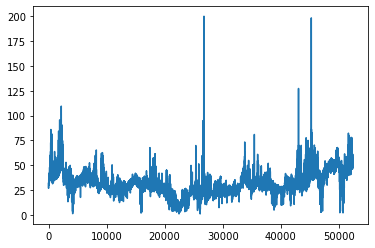

---------- Split 1/1 ----------


Y_df.shape 	(52416, 3)
X_df.shape 	(52416, 12)
Y_balanced_df.shape 	(52416, 3)
X_balanced_df.shape 	(52416, 12)
Train Validation splits
                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0.0         2016-12-27 2018-12-24 23:00:00
          1.0         2013-01-01 2016-12-26 23:00:00
Total data 			52416 time stamps
Available percentage=100.0, 	52416 time stamps
Train percentage=66.67, 	34944.0 time stamps
Outsample percentage=33.33, 	17472.0 time stamps


Train Validation splits
                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0.0         2013-01-01 2016-12-26 23:00:00
          1.0         2016-12-27 2018-12-24 23:00:00
Total data 			52416 time stamps
Available percentage=100.0, 	52416 time stamps
Train percentage=33.33

In [7]:
import matplotlib.pyplot as plt

mc0 = {# Architecture parameters
      'input_size_multiplier': 7,
      'output_size': 24,
      'shared_weights': False,
      'activation': 'selu',
      'initialization': 'he_normal',
      'stack_types': ['exogenous_tcn']+1*['identity'],
      'n_blocks': [1, 1],
      'n_layers': [2, 2],
      'n_hidden': 364,
      #'n_hidden_list': 2*[[462,462]],
      'n_polynomials': 2,
      'n_harmonics': 1,
      'exogenous_n_channels': 3,
      'x_s_n_hidden': 0, # TODO: referencia dinámica vs datasets
      # Regularization and optimization parameters
      'batch_normalization': False,
      'dropout_prob_theta': 0.2,
      'dropout_prob_exogenous': 0.2,
      'learning_rate': 0.0005, #0.002,
      'lr_decay': 0.64,
      'n_lr_decay_steps': 3,
      'weight_decay': 0.00015,
      'n_iterations': 1000,
      'early_stopping': 8,
      'eval_steps': 50,
      'n_val_weeks': 52*2,
      'loss': 'PINBALL',
      'loss_hypar': 0.5, #0.49,
      'val_loss': 'MAE',
      'l1_theta': 0,
      # Data parameters
      'normalizer_y': None,
      'normalizer_x': 'median',
      'window_sampling_limit': 50_000,
      'complete_inputs': True,
      'frequency':'H',
      'seasonality': 24,
      'idx_to_sample_freq': 24,
      'include_var_dict': {'y': [-2, -3, -8],
                           'Exogenous1': [-1, -2, -8],
                           'Exogenous2': [-1, -2, -8],
                           'week_day': [-1]},
      'batch_size': 256,
      'random_seed': 10}

mc = mc0
dataset = ['NP']
# dataset = ['BE']
# dataset = ['BE', 'FR']
# dataset = ['NP', 'PJM']
# dataset = ['NP', 'PJM', 'BE', 'FR']
if len(dataset)>1: mc['x_s_n_hidden'] = 2

Y_df, X_df, S_df = EPF.load_groups(directory='data', groups=dataset)

plt.plot(Y_df.y.values)
plt.show()

y_total, y_hat_total, mask_total, meta_data = run_val_nbeatsx(mc=mc, Y_df=Y_df, X_df=X_df, S_df=S_df,
                                                              trials=None, trials_file_name=None, final_evaluation=False, return_predictions=True)

In [8]:
np.mean(np.abs(y_total.flatten()-y_hat_total.flatten()))

1.7866783

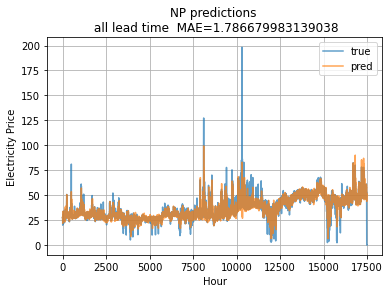

In [9]:
for i, market_data in enumerate(meta_data):
    market = market_data['unique_id']
    y_hat_plot = y_hat_total[i,:,:].reshape(-1)
    y_true_plot = y_total[i,:,:].reshape(-1)
    
    performance = np.round(mae(y=y_true_plot, y_hat=y_hat_plot), 5)
    plt.plot(range(len(y_true_plot)), y_true_plot, label='true', alpha=0.7)
    plt.plot(range(len(y_hat_plot)), y_hat_plot, label='pred', alpha=0.7)
    plt.title(f"{market} predictions \n all lead time  MAE={performance}")
    plt.xlabel('Hour')
    plt.ylabel('Electricity Price')
    plt.legend()
    plt.grid()
    plt.show()